## Test time

In [2]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NaiveMovingAverage
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.utils.missing_values import fill_missing_values
from dotenv import load_dotenv
import os
import numpy as np

# Change working directory to the 'src' folder
# os.chdir(os.path.join(os.getcwd(), 'src'))

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Load .env file
env_path = '../config/.env'
load_dotenv(env_path)
API_KEY_ID = os.getenv('API_KEY')
API_SECRET_KEY = os.getenv('SECRET_KEY')

# Alpaca API base URL
BASE_URL = "https://data.alpaca.markets/v2"

# Endpoint for historical stock data
ENDPOINT = "/stocks/trades"

/home/manish/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /home/manish/Documents/NUS stuff/Data Science Practice/machine learning/Alpaca Project/src


In [3]:
# Headers for authentication
headers = {
    "APCA-API-KEY-ID": API_KEY_ID,
    "APCA-API-SECRET-KEY": API_SECRET_KEY,
}

In [4]:
end_time = datetime.now() - timedelta(days = 2)
print(end_time)
start_time = end_time - timedelta(days=1)
print(start_time)

2025-03-29 20:17:51.329270
2025-03-28 20:17:51.329270


In [5]:
def fetch_all_trades(symbol, start, end):
    """Fetch all trades with pagination handling"""
    all_trades = []
    params = {
        "symbols": symbol,
        "start": start.isoformat() + "Z",
        "end": end.isoformat() + "Z",
        "limit": 10000,
        "feed": "sip",
        "sort": "asc"
    }
    
    while True:
        response = requests.get(BASE_URL + ENDPOINT, headers=headers, params=params)
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code} - {response.text}")
            break
            
        data = response.json()
        all_trades.extend(data["trades"][symbol])
        
        # Check for more pages
        if "next_page_token" in data and data["next_page_token"]:
            params["page_token"] = data["next_page_token"]
        else:
            break
            
    return all_trades

In [6]:
# Fetch all trades
print("Fetching trade data...")
all_trades = fetch_all_trades("AAPL", start_time, end_time)
print(f"Fetched {len(all_trades)} trades")

Fetching trade data...
Fetched 3527 trades


In [7]:
# Process into DataFrame
df = pd.DataFrame([{
    "Timestamp": pd.to_datetime(trade["t"]).tz_localize(None),
    "Price": trade["p"],
    "Size": trade["s"],
    "Conditions": ",".join(trade["c"])
} for trade in all_trades])

# Sort by timestamp
df = df.sort_values("Timestamp").reset_index(drop=True)
#-----------

In [8]:
df.head()

,Timestamp,Price,Size,Conditions
0,2025-03-28 20:17:52.859376845,217.74,18,"@,F,T,I"
1,2025-03-28 20:17:52.860489877,217.74,18,"@,F,T,I"
2,2025-03-28 20:17:52.862162681,217.74,18,"@,F,T,I"
3,2025-03-28 20:17:52.889257421,217.74,18,"@,F,T,I"
4,2025-03-28 20:17:52.889558333,217.74,36,"@,F,T,I"


In [9]:
df.shape[0]

3527

In [10]:
# Resample liquidity by 30-minute windows
liquidity = df.set_index('Timestamp').resample('30T').agg({
    'Price': 'count',  # Trade frequency
    'Size': 'sum'      # Total volume
})

In [11]:
liquidity.head()

,Price,Size
Timestamp,,
2025-03-28 20:00:00,554,60432
2025-03-28 20:30:00,844,129921
2025-03-28 21:00:00,392,14201
2025-03-28 21:30:00,546,10554
2025-03-28 22:00:00,292,12679


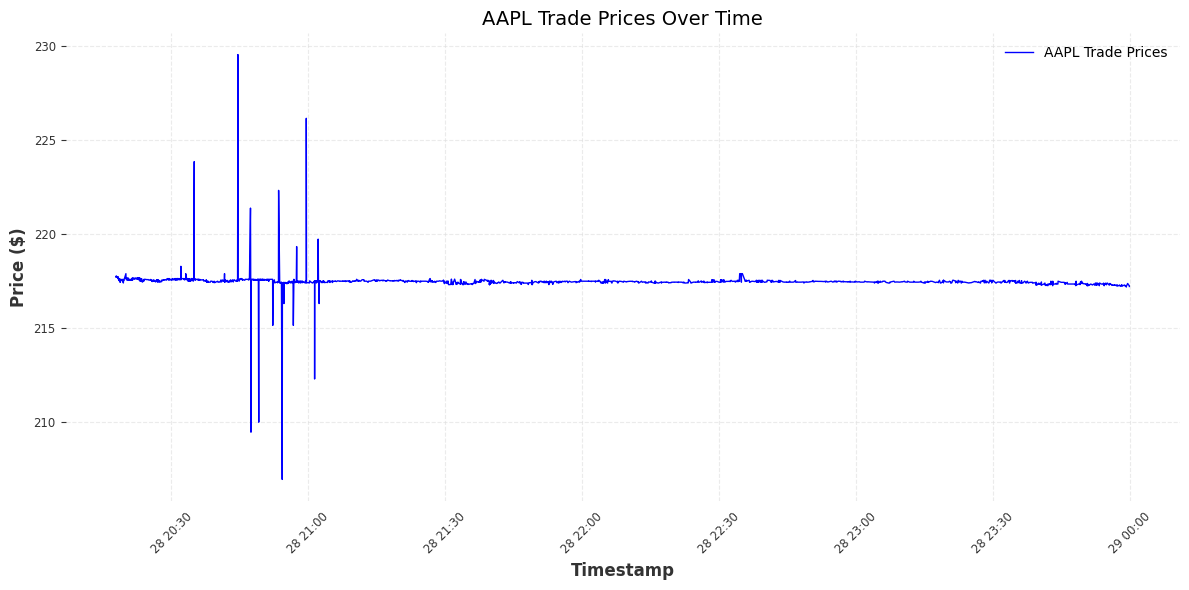

In [12]:
# --- Plotting ---
plt.figure(figsize=(12, 6))  # Set figure size

# Plot price vs. time
plt.plot(df["Timestamp"], df["Price"], 
         linestyle='-', 
         linewidth=1, 
         color='blue',
         label='AAPL Trade Prices')

# Customize the plot
plt.title("AAPL Trade Prices Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add gridlines

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()  # Prevent label cutoff
plt.show()

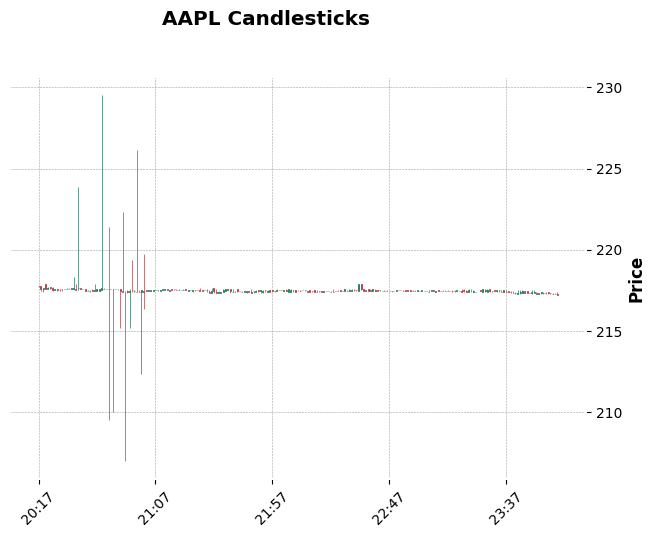

In [13]:
import mplfinance as mpf

# Resample to OHLC (e.g., 1-minute intervals)
ohlc = df.set_index('Timestamp').resample('1T').agg({
    'Price': ['first', 'max', 'min', 'last']
})
ohlc.columns = ['Open', 'High', 'Low', 'Close']

# Plot candlesticks
mpf.plot(ohlc, type='candle', style='charles', title='AAPL Candlesticks')

In [14]:
ohlc.head()

,Open,High,Low,Close
Timestamp,,,,
2025-03-28 20:17:00,217.74,217.78,217.7100,217.7400
2025-03-28 20:18:00,217.75,217.75,217.4500,217.5880
2025-03-28 20:19:00,217.59,217.63,217.4057,217.6300
2025-03-28 20:20:00,217.90,217.90,217.5501,217.5501
2025-03-28 20:21:00,217.55,217.67,217.5500,217.6200


In [15]:
# True Range (Volatility Measure)
ohlc['TR'] = np.maximum(
    ohlc['High'] - ohlc['Low'],
    np.maximum(abs(ohlc['High'] - ohlc['Close'].shift()), 
               abs(ohlc['Low'] - ohlc['Close'].shift()))
)

# Donchian Channels (20-minute window)
window = 20
ohlc['Donchian_High'] = ohlc['High'].rolling(window).max()
ohlc['Donchian_Low'] = ohlc['Low'].rolling(window).min()

# Heikin-Ashi Smoothed Candles (trend filtering)
ohlc['HA_Close'] = (ohlc['Open'] + ohlc['High'] + ohlc['Low'] + ohlc['Close']) / 4
ohlc['HA_Open'] = (ohlc['Open'].shift() + ohlc['Close'].shift()) / 2

In [16]:
# Merge volume from raw trades
volume = df.set_index('Timestamp').resample('1T')['Size'].sum()
ohlc = ohlc.merge(volume.rename('Volume'), left_index=True, right_index=True)

# Volume-Weighted Metrics
ohlc['VWAP'] = (ohlc['Close'] * ohlc['Volume']).cumsum() / ohlc['Volume'].cumsum()
ohlc['Volume_Spike'] = ohlc['Volume'] / ohlc['Volume'].rolling(20).mean()

# Price-Volume Divergence
ohlc['PVT'] = (ohlc['Close'].pct_change() * ohlc['Volume']).cumsum()

In [17]:
# Tick-Level Imbalance
df['Imbalance'] = np.where(df['Price'] > df['Price'].shift(), df['Size'], 
                          -df['Size'])
ohlc['Imbalance_1min'] = df.set_index('Timestamp').resample('1T')['Imbalance'].sum()

# Large Trade Detection
block_threshold = df['Size'].quantile(0.95)
ohlc['Block_Trades'] = df[df['Size'] > block_threshold].set_index('Timestamp').resample('1T')['Size'].count()

In [18]:
# Engulfing Patterns (requires 2 candles)
ohlc['Bullish_Engulfing'] = (
    (ohlc['Close'] > ohlc['Open']) & 
    (ohlc['Close'].shift() < ohlc['Open'].shift()) &
    (ohlc['Close'] > ohlc['Open'].shift()) &
    (ohlc['Open'] < ohlc['Close'].shift())
).astype(int)

# Doji Detection (indecision)
ohlc['Doji'] = (abs(ohlc['Open'] - ohlc['Close']) / 
                (ohlc['High'] - ohlc['Low'] + 1e-9) < 0.1).astype(int)

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                   vertical_spacing=0.05,
                   row_heights=[0.7, 0.3])

# 1. Candlestick plot with VWAP and Donchian Channels
fig.add_trace(go.Candlestick(x=ohlc.index,
                            open=ohlc['Open'],
                            high=ohlc['High'],
                            low=ohlc['Low'],
                            close=ohlc['Close'],
                            name='AAPL',
                            increasing_line_color='green',
                            decreasing_line_color='red'), row=1, col=1)

# Add VWAP
fig.add_trace(go.Scatter(x=ohlc.index,
                        y=ohlc['VWAP'],
                        line=dict(color='cyan', width=2),
                        name='VWAP'), row=1, col=1)

# Add Donchian Channels
fig.add_trace(go.Scatter(x=ohlc.index,
                        y=ohlc['Donchian_High'],
                        line=dict(color='blue', width=1, dash='dot'),
                        name='Donchian High'), row=1, col=1)

fig.add_trace(go.Scatter(x=ohlc.index,
                        y=ohlc['Donchian_Low'],
                        line=dict(color='blue', width=1, dash='dot'),
                        name='Donchian Low'), row=1, col=1)

# 2. Volume plot
fig.add_trace(go.Bar(x=ohlc.index,
                    y=ohlc['Volume'],
                    name='Volume',
                    marker_color='rgba(100, 100, 255, 0.4)'), row=2, col=1)

# Update layout
fig.update_layout(
    title='AAPL with VWAP & Donchian Channels (Interactive)',
    xaxis_rangeslider_visible=False,
    height=800,
    hovermode='x unified',
    showlegend=True,
    template='plotly_white'  # Try 'plotly_white' for light mode
)

# Configure axes
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)

# Add range selector buttons
fig.update_xaxes(
    rangeselector=dict(
        buttons=([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=1, label="1h", step="hour", stepmode="backward"),
            dict(count=4, label="4h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()